In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd

In [2]:
print('Starting planet search rev3: Spline corrected and BIC selection')

af_stars = pd.read_csv('data/catalogues/rev_AF_stars.csv', dtype={'kic': str})
af_stars = af_stars[af_stars['dSct'] > 0]

kep_lc = glob.glob('data/lightcurves/spline corrected PDC/lc/*.csv')
ids = [k.split('kplr')[-1].split('.csv')[0].lstrip('0') for k in kep_lc]

files = pd.DataFrame({'kic': ids, 'file': kep_lc})
df = af_stars.merge(files, left_on='kic', right_on='kic')

missing = af_stars[~af_stars['kic'].isin(df['kic'])]
print(f"There are {len(missing)} missing stars from the sample")

Starting planet search rev3: Spline corrected and BIC selection
There are 1 missing stars from the sample


In [3]:
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares, LombScargle
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import glob

def preprocess_lc(x, y, yerr, ax=None):
    mu = np.median(y)
    y = (y / mu - 1) * 1e3
    yerr = yerr * 1e3
    
    # Identify outliers
    m = np.ones(len(y), dtype=bool)
    for i in range(10):
        y_prime = np.interp(x, x[m], y[m])
        smooth = savgol_filter(y_prime, 1001, polyorder=3)
        resid = y - smooth
        sigma = np.sqrt(np.mean(resid ** 2))
        m0 = np.abs(resid) < 3 * sigma
        if m.sum() == m0.sum():
            m = m0
            break
        m = m0

    # Discard outliers
    m = (resid < 3 * sigma) & (resid > -3 * sigma)
    
    if ax is not None:
        # Plot the data
        plt.plot(x, y, "k", label="data")
        plt.plot(x, smooth)
        plt.plot(x[~m], y[~m], "xr", label="outliers")
        plt.legend()
        plt.xlim(x.min(), x.max())
        plt.xlabel("Time")
        plt.ylabel("Flux [ppt]")
        
    
    # Make sure that the data type is consistent
    x = np.ascontiguousarray(x[m], dtype=np.float64)
    y = np.ascontiguousarray(y[m], dtype=np.float64)
    yerr = np.ascontiguousarray(yerr[m], dtype=np.float64)
    smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)
    return x, y, yerr, smooth

def estimate_SNR(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return y / (bkg / count)

def amplitude_spectrum(t, y, fmin=None, fmax=None, oversample_factor=10.0):
    
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)

    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = 0.5 / np.median(np.diff(t))  # *nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4.0 / len(t))
    amp = np.sqrt(sc) * fct

    return freq, amp

In [79]:
from astropy.timeseries import LombScargle, BoxLeastSquares
from scipy.optimize import curve_fit

def grad_model(time, freq, amp, phi):
    factor = 2 * np.pi * freq * time + phi
    return np.array([
        -2*np.pi*amp*time*np.sin(factor),
        np.cos(factor),
        -1 * amp * np.sin(factor)
    ]).T

def dft_phase(x, y, f):
    expo = 2.0 * np.pi * f * x
    ft_real = np.sum(y * np.cos(expo))
    ft_imag = np.sum(y * np.sin(expo))
    return np.arctan2(ft_imag, ft_real)

def model(time, freq, amp, phi):
    return amp * np.cos((2 * np.pi * freq * time) + phi)

def fit_model(time, flux, theta):
    popt, _ = curve_fit(model, time, flux, p0=theta, jac=grad_model)
    return popt

def initialize_theta(time, flux, SNR, fmin, fmax):
    """
    Returns an initial estimate of the frequency, amplitude, and phase of 
    the highest amplitude signal given a light curve (time, flux)
    """
    f, a = amplitude_spectrum(time, flux, fmin=fmin, fmax=fmax, oversample_factor=5.)
    # Get freq of max amplitude
    f0 = find_highest_peak(f, a)
    # Calculate a0 at f0
    a0 = np.sqrt(LombScargle(time, flux).power(f0, method="fast", normalization="psd")) * np.sqrt(4.0 / len(time))
    # Calculate phi0, since ASTC need to negative it
    phi0 = -1 * dft_phase(time, flux, f0)
    # Finally, estimate the SNR of the peak
    return [f0, a0, phi0], SNR[np.nanargmax(a)]

In [80]:
# Stuff for low freq

In [89]:
def initialize_theta_low(time, flux, fmin, fmax):
    f, a = amplitude_spectrum(time, flux, fmin=fmin, fmax=fmax, oversample_factor=5.)
    noise = estimate_background(f,a, log_width=0.05)
    snr = a/noise
    # Get freq of max SNR
    f0 = find_highest_peak(f, snr)
    # Calculate a0 at f0
    a0 = np.sqrt(LombScargle(time, flux).power(f0, method="fast", normalization="psd")) * np.sqrt(4.0 / len(time))
    # Calculate phi0, since ASTC need to negative it
    phi0 = -1 * dft_phase(time, flux, f0)
    
#     plt.plot(f, snr)
#     plt.show()
    return [f0, a0, phi0], snr[np.nanargmax(snr)], f, a

def find_highest_peak(f, a):
    """
    Find the frequency of the highest peak in the periodogram, using a
    3-point parabolic interpolation.
    """
    nu, p = f, a
    nu, p = np.atleast_1d(nu, p)

    # Get index of highest peak.
    imax = np.argmax(p)

    # Determine the frequency value by parabolic interpolation
    if imax == 0 or imax == p.size - 1:
        nu_peak = p[imax]
    else:
        # Get values around the maximum.
        frq1 = nu[imax-1]
        frq2 = nu[imax]
        frq3 = nu[imax+1]
        y1 = p[imax-1]
        y2 = p[imax]
        y3 = p[imax+1]

        # Parabolic interpolation formula.
        t1 = (y2-y3) * (frq2-frq1)**2 - (y2-y1) * (frq2-frq3)**2
        t2 = (y2-y3) * (frq2-frq1) - (y2-y1) * (frq2-frq3)
        nu_peak = frq2 - 0.5 * t1/t2
    return nu_peak

def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

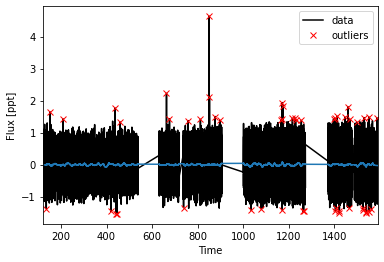

In [123]:
fig, ax = plt.subplots()
# row = df.iloc[505]
row = df[df.kic == '5202905']
time, flux, yerr, sm = preprocess_lc(*np.loadtxt(row.file.values[0]).T, ax=ax)

In [124]:
# plt.plot(*amplitude_spectrum(time, flux - smooth), c='r')
# plt.plot(*amplitude_spectrum(time, flux - 0))
# plt.xlim(0,1)

In [125]:
# def prewhiten(x, y, fmin=2, snr_cutoff=4, log_width=0.01, maxiter=100):
#     prew = np.copy(y)
#     nyq = 0.5 / np.median(np.diff(x))
#     df = 1.0 / (x.max() - x.min())
#     fmax = 2*nyq - fmin # Make sure to mirror .. !

#     f,a = amplitude_spectrum(x, prew, fmin=fmin, fmax=fmax, oversample_factor=5.)
#     SNR = estimate_SNR(f,a, log_width=log_width)
#     # Calculate initial estimate
#     theta, f_snr = initialize_theta(x, prew, SNR, fmin, fmax)

#     pre_res = []
#     # Run until either we reach minimum SNR or cutoff iterations
#     while (f_snr > snr_cutoff) & (len(pre_res) < maxiter):
#         res = fit_model(x, prew, theta)
#         prew -= model(x, *res)
#         pre_res.append(res)
#         theta, f_snr = initialize_theta(x, prew, SNR, fmin, fmax)
#     pre_res = np.array(pre_res)
            
#     return x, prew, pre_res, f, SNR

In [126]:
def prewhiten(x, y, transit_cutoff=2, snr_cutoff=4, log_width=0.01, maxiter=120):
    prew = np.copy(y)
    nyq = 0.5 / np.median(np.diff(x))
    df = 1.0 / (x.max() - x.min())
    fmin, fmax = df, 2*nyq - transit_cutoff # Make sure to mirror .. !

    f,a = amplitude_spectrum(x, prew, fmin=fmin, fmax=fmax, oversample_factor=5.)
    SNR = estimate_SNR(f,a, log_width=log_width)
    # Calculate initial estimate
    theta, f_snr = initialize_theta(x, prew, SNR, fmin, fmax)

    pre_res = []
    # Run until either we reach minimum SNR or cutoff iterations
    while (f_snr > snr_cutoff) & (len(pre_res) < maxiter):
        res = fit_model(x, prew, theta)
        
        if res[0] < transit_cutoff:
            # We need to do our model selection:
            bls = BoxLeastSquares(x, prew)
            bls_power = bls.power([1/theta[0]], 0.2)
            bls_transit = bls.model(x, bls_power.period[0], bls_power.duration[0], bls_power.transit_time[0])

            # Now calculate the BIC of both models:
            BIC = [-2 * (-0.5 * np.sum((prew - model(x, *res)) ** 2)) + np.log(len(x)) * 2, 
                   -2 * (-0.5 * np.sum((prew - bls_transit) ** 2)) + np.log(len(x)) * 2]

            if np.argmin(BIC) == 1:
                break
        
        prew -= model(x, *res)
        pre_res.append(res)
        theta, f_snr = initialize_theta(x, prew, SNR, fmin, fmax)
    pre_res = np.array(pre_res)
            
    return x, prew, pre_res, f, SNR

In [127]:
x, prew, res, f, SNR = prewhiten(time, flux)

/home/daniel/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


hi
hi
hi


(0.0, 2.0)

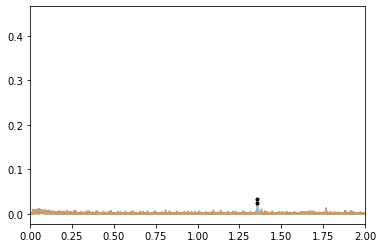

In [131]:
plt.plot(*amplitude_spectrum(time, flux, fmax=48), alpha=0.5)
plt.plot(*amplitude_spectrum(x, prew), alpha=0.5)
plt.plot(res[:,0], res[:,1], '.k')
# plt.xlim(16.82, 16.84)

(0.0, 2.0)

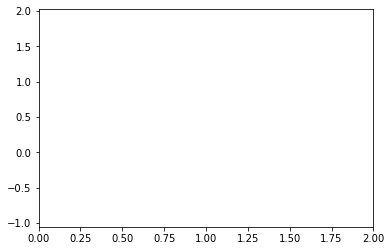

In [130]:
plt.plot(x, prew)
plt.xlim(0,2)

In [103]:
old = glob.glob(f'prewhitening/results/spline corrected/prewhitened/*{row.kic}*')[0]
old_t, old_f, old_y = np.loadtxt(old, unpack=True)

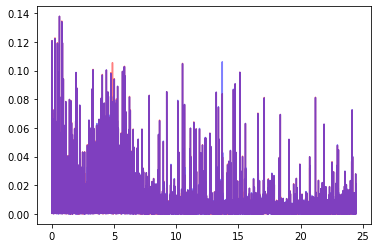

In [104]:
plt.plot(*amplitude_spectrum(old_t, old_f), alpha=0.5, c='r')
plt.plot(*amplitude_spectrum(x, prew), alpha=0.5, c='b')
# plt.xlim(0,5)

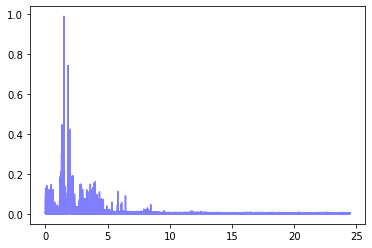

In [69]:
plt.plot(*amplitude_spectrum(x, prew), alpha=0.5, c='b')